# Coding Discussion 06
## Author: Vince Egalla

### Instruction 
Building off what we did in lecture this week, please build a model that predicts the _log_ selling price of a house in DC (`PRICE`). Please use what you've learned of the `sklearn` library to accomplish this task.  

I've split this dataset into a training and test dataset (so you don't need to split it on your own). Using the training data, build a model that predicts the price of a residential unit in District of Columbia.

You may use any feature in the dataset to generate a model. Some things to keep in mind:

- Be sure to predict the log Price, not the raw Price
- Be sure to pre-process your data. 
- Be careful of missing data values. You can do whatever you like with them. 
- Try different models, some algorithms perform better on a specific data outcome than others. 
- Be sure to tune your model (if it has relevant tuning parameters).

Once you've come up with a model that you think performs well, please test your model on the provided test data and report the mean squared error. 

### Data 

The provided data comes from the D.C. Residential Properties dataset downloaded from Kaggle and available via Open Data DC. The following provides a description of the data as provided at this [link](https://dcdatahub.maps.arcgis.com/sharing/rest/content/items/c5fb3fbe4c694a59a6eef7bf5f8bc49a/info/metadata/metadata.xml?format=default&output=html):

> Computer Assisted Mass Appraisal (CAMA) database. The dataset contains attribution on housing characteristics for residential properties, and was created as part of the DC Geographic Information System (DC GIS) for the DC Office of the Chief Technology Officer (OCTO) and participating D.C. government agencies. This data is used for the planning and management of Washington, D.C. by local government agencies.

Again, the data has been pre-split into a training and test dataset. 

### Dependencies

In [1]:
## Copied from "Comparing-and-Tuning-Models.html"

# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
## Read in training data
train = pd.read_csv("../train_data.csv")

train.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


In [3]:
## Read in test data
test = pd.read_csv("../test_data.csv")

test.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,89279,5260 0823,2.0,1.0,1.0,Forced Air,Y,1.0,6.0,3.0,...,1.0,Comp Shingle,11.0,Hardwood/Carp,1.0,0.0,11,688,2018-07-22T18:01:43.000Z,12.409013
1,40572,2605 0056,3.0,0.0,13.0,Hot Water Rad,N,2.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,2.0,1.0,24,2064,2018-07-22T18:01:43.000Z,13.513053
2,32817,1956 0116,4.0,1.0,7.0,Warm Cool,Y,1.0,10.0,5.0,...,2.0,Built Up,11.0,Hardwood/Carp,1.0,2.0,12,4583,2018-07-22T18:01:43.000Z,14.417091
3,12939,0939 0056,3.0,1.0,1.0,Forced Air,Y,1.0,10.0,4.0,...,13.0,Neopren,6.0,Hardwood,1.0,2.0,11,2147,2018-07-22T18:01:43.000Z,13.547631
4,59018,3200 0254,2.0,0.0,13.0,Hot Water Rad,N,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,1576,2018-07-22T18:01:43.000Z,13.023647


<AxesSubplot:>

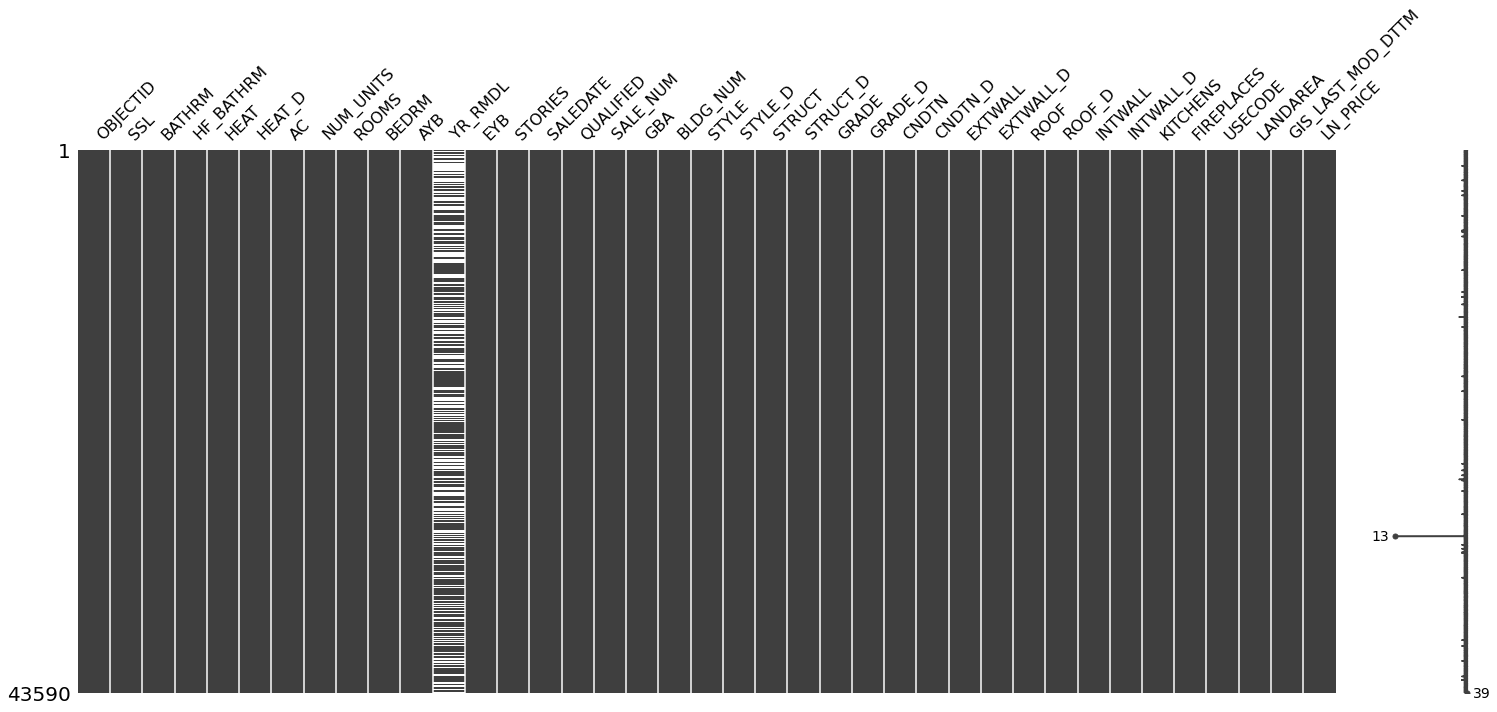

In [4]:
## Check for missing data on ln_price in train
miss.matrix(train)

<AxesSubplot:>

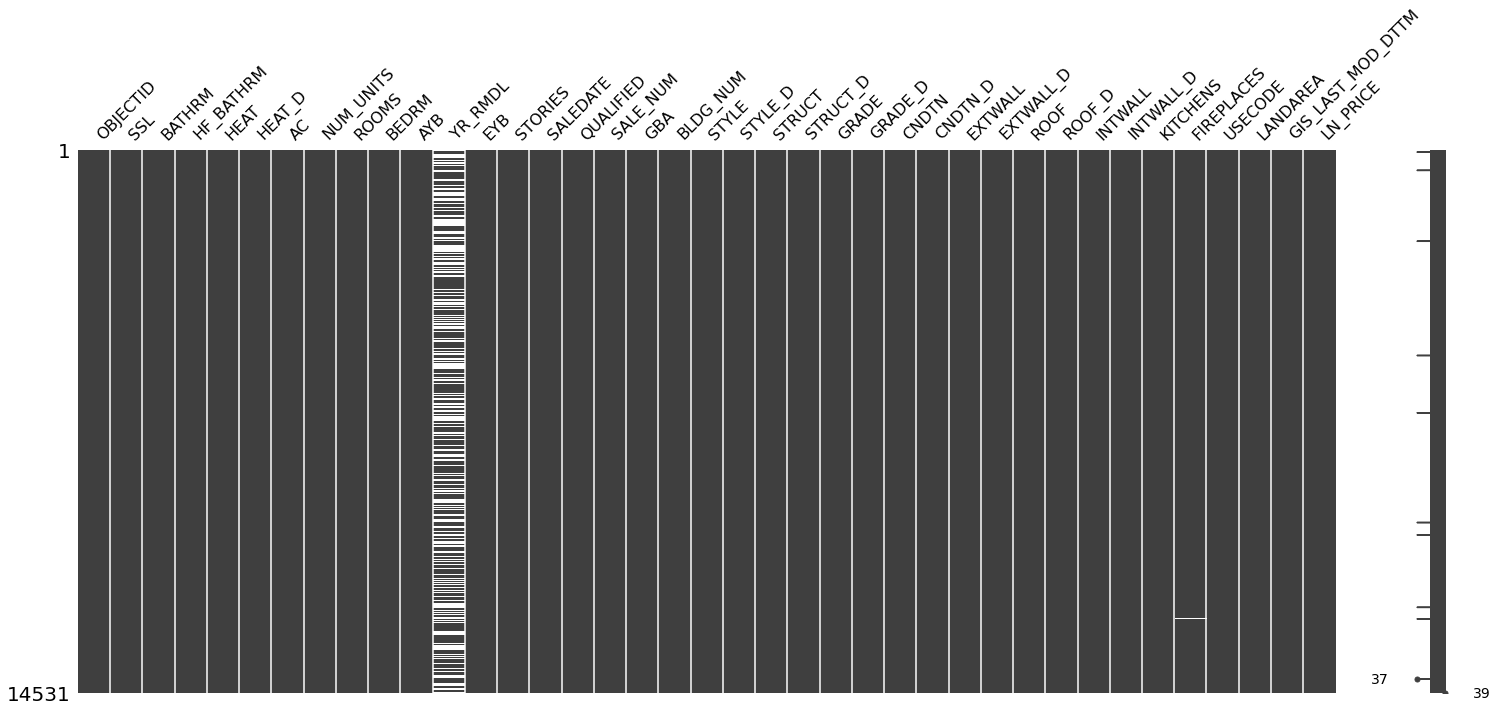

In [5]:
## Check for missing data on ln_price in test
miss.matrix(test)

In [6]:
## Create non-bedroom room variable
train['RM'] = train['ROOMS'] - train['BEDRM']
test['RM'] = test['ROOMS'] - test['BEDRM']

## Summary statistics
train['RM'].describe().T

count    43577.000000
mean         3.996971
std          1.802213
min        -48.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         21.000000
Name: RM, dtype: float64

In [7]:
## Check values of negative non-room rooms
train.loc[train['RM'] < 0,]

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE,RM
93,52578,2853 0845,4.0,0.0,7.0,Warm Cool,Y,2.0,11.0,12.0,...,Metal- Sms,6.0,Hardwood,2.0,0.0,24,1791,2018-07-22T18:01:43.000Z,12.691580,-1.0
513,80765,4471 0177,1.0,1.0,13.0,Hot Water Rad,N,1.0,1.0,3.0,...,Built Up,6.0,Hardwood,1.0,0.0,11,1232,2018-07-22T18:01:43.000Z,11.401994,-2.0
631,42560,2577 0035,4.0,4.0,13.0,Hot Water Rad,Y,4.0,12.0,13.0,...,Metal- Sms,6.0,Hardwood,4.0,0.0,24,1737,2018-07-22T18:01:43.000Z,13.790193,-1.0
1042,80142,4327 1221,3.0,1.0,1.0,Forced Air,Y,1.0,0.0,3.0,...,Comp Shingle,6.0,Hardwood,0.0,0.0,11,2508,2018-07-22T18:01:43.000Z,13.418713,-3.0
1079,25564,1453 0881,2.0,1.0,13.0,Hot Water Rad,Y,1.0,3.0,4.0,...,Comp Shingle,6.0,Hardwood,1.0,1.0,12,7475,2018-07-22T18:01:43.000Z,12.528156,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42223,104430,5896 0046,2.0,0.0,1.0,Forced Air,Y,1.0,0.0,2.0,...,Comp Shingle,6.0,Hardwood,1.0,0.0,13,1894,2018-07-22T18:01:43.000Z,12.449019,-2.0
42460,48852,2893 0063,1.0,0.0,11.0,Gravity Furnac,N,1.0,0.0,6.0,...,Metal- Sms,2.0,Carpet,1.0,0.0,11,1463,2018-07-22T18:01:43.000Z,11.606562,-6.0
42804,89686,5359 0312,1.0,0.0,1.0,Forced Air,N,1.0,0.0,3.0,...,Comp Shingle,2.0,Carpet,1.0,0.0,12,4510,2018-07-22T18:01:43.000Z,11.608236,-3.0
42954,56700,3135 0804,5.0,1.0,1.0,Forced Air,Y,1.0,7.0,8.0,...,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2023,2018-07-22T18:01:43.000Z,13.244581,-1.0


In [8]:
## Convert negative to None values to exclude from analysis
train.loc[train['RM'] < 0, 'RM'] = None
test.loc[test['RM'] < 0, 'RM'] = None

train.loc[train['ROOMS'] < train['BEDRM'],]


,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE,RM
93,52578,2853 0845,4.0,0.0,7.0,Warm Cool,Y,2.0,11.0,12.0,...,Metal- Sms,6.0,Hardwood,2.0,0.0,24,1791,2018-07-22T18:01:43.000Z,12.691580,NaN
513,80765,4471 0177,1.0,1.0,13.0,Hot Water Rad,N,1.0,1.0,3.0,...,Built Up,6.0,Hardwood,1.0,0.0,11,1232,2018-07-22T18:01:43.000Z,11.401994,NaN
631,42560,2577 0035,4.0,4.0,13.0,Hot Water Rad,Y,4.0,12.0,13.0,...,Metal- Sms,6.0,Hardwood,4.0,0.0,24,1737,2018-07-22T18:01:43.000Z,13.790193,NaN
1042,80142,4327 1221,3.0,1.0,1.0,Forced Air,Y,1.0,0.0,3.0,...,Comp Shingle,6.0,Hardwood,0.0,0.0,11,2508,2018-07-22T18:01:43.000Z,13.418713,NaN
1079,25564,1453 0881,2.0,1.0,13.0,Hot Water Rad,Y,1.0,3.0,4.0,...,Comp Shingle,6.0,Hardwood,1.0,1.0,12,7475,2018-07-22T18:01:43.000Z,12.528156,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42223,104430,5896 0046,2.0,0.0,1.0,Forced Air,Y,1.0,0.0,2.0,...,Comp Shingle,6.0,Hardwood,1.0,0.0,13,1894,2018-07-22T18:01:43.000Z,12.449019,NaN
42460,48852,2893 0063,1.0,0.0,11.0,Gravity Furnac,N,1.0,0.0,6.0,...,Metal- Sms,2.0,Carpet,1.0,0.0,11,1463,2018-07-22T18:01:43.000Z,11.606562,NaN
42804,89686,5359 0312,1.0,0.0,1.0,Forced Air,N,1.0,0.0,3.0,...,Comp Shingle,2.0,Carpet,1.0,0.0,12,4510,2018-07-22T18:01:43.000Z,11.608236,NaN
42954,56700,3135 0804,5.0,1.0,1.0,Forced Air,Y,1.0,7.0,8.0,...,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2023,2018-07-22T18:01:43.000Z,13.244581,NaN


In [9]:
## Remove observations with NA values in X
train = train.dropna(how='any', subset=['BATHRM','RM','LANDAREA','GBA','BEDRM'])
test = test.dropna(how='any', subset=['BATHRM','RM','LANDAREA','GBA','BEDRM'])

In [10]:
train_y = train[['LN_PRICE']] # OUTCOME: log selling price (some houses are ridiculuously expensive)
train_X = train[['BATHRM','RM','LANDAREA','GBA','BEDRM']] # PREDICTORS: simplified for our purposes

train_X.head()

,BATHRM,RM,LANDAREA,GBA,BEDRM
0,3.0,5.0,2234,1260,4.0
1,2.0,4.0,3850,1426,3.0
2,2.0,5.0,7866,2270,4.0
3,1.0,3.0,2739,1278,3.0
4,2.0,7.0,2097,2936,4.0


In [11]:
test_y = test[['LN_PRICE']] # OUTCOME: log selling priceb
test_X = test[['BATHRM','RM','LANDAREA','GBA','BEDRM']] # PREDICTORS

test_X.head()

,BATHRM,RM,LANDAREA,GBA,BEDRM
0,2.0,3.0,688,1683,3.0
1,3.0,5.0,2064,1548,4.0
2,4.0,5.0,4583,3840,5.0
3,3.0,6.0,2147,1776,4.0
4,2.0,3.0,1576,1180,3.0


### Run the models with default parameters

In [12]:
## Number of Folds
fold_generator = KFold(n_splits=5, shuffle=True,random_state=11)

## MSE as scoring metric
use_metrics = ["neg_mean_squared_error"]

In [13]:
## Linear Model
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [14]:
## KNN
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [15]:
## Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [16]:
## Bagging
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [17]:
## Random Forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [18]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.522654
1,lm,0.546046
2,lm,0.520269
3,lm,0.527022
4,lm,0.578231
5,knn,0.601443
6,knn,0.644771
7,knn,0.595802
8,knn,0.607764
9,knn,0.645727


### Tuning (KNN, Decision Tree, Random Forest)

In [19]:
# KNN tuning
## Values to explore
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

## Run each model
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

## Fit model
tune_knn.fit(train_X,train_y)

## View best parameter
tune_knn.best_params_

{'n_neighbors': 100}

In [20]:
## View respective score
tune_knn.best_score_

-0.5420146332665964

In [21]:
# Decision Tree tuning
## Run each models for values 1 - 10 on max_depth
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

## Fit model
tune_dt.fit(train_X,train_y)

## View best parameter
tune_dt.best_params_

{'max_depth': 7}

In [22]:
## View respective score
tune_dt.best_score_

-0.4873525898471013

In [23]:
# Random Forest tuning
## Values to explore
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2,3,4]} 

## Run each model
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

## Fit model
tune_rf.fit(train_X,train_y) 

## View best parameter
tune_rf.best_params_

{'max_depth': 3, 'max_features': 3, 'n_estimators': 500}

In [24]:
## View respective score
tune_rf.best_score_

-0.5144880527820278

### Compare all models with pipeline

In [25]:
## Pre-processing specification
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','RM','LANDAREA','GBA','BEDRM'])])


## Model Pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


## Specify the models and their repsective tuning parameters. 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with tuning
    {'model' : [KNN()],
     'model__n_neighbors':[100]},
    
    # Decision Tree with the tuning
    {'model': [DTree()],
     'model__max_depth':[7]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with tuning
    {'model' : [RF()],
     'model__max_depth':[3],
     'model__max_features':[3],
     'model__n_estimators':[500]},
]


## Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



In [26]:
# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'RM',
                                                                          'LANDAREA',
                                                                          'GBA',
                                                                          'BEDRM'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=100)],
                          'model__n_neighbors': [100]},
                     

In [27]:
search.best_score_

-0.4860606475371009

In [28]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=100), 'model__n_neighbors': 100}

### Test Performance

In [29]:
pred_y = pd.DataFrame(search.predict(test_X)).rename(columns={0: 'prediction'})

In [30]:
m.mean_squared_error(test_y,pred_y)

0.47676141457485444

In [31]:
prediction = pd.concat([pred_y, test_y], axis = 1)

prediction.head()

,prediction,LN_PRICE
0,12.985436,12.409013
1,13.329022,13.513053
2,14.090982,14.417091
3,13.377706,13.547631
4,12.634986,13.023647


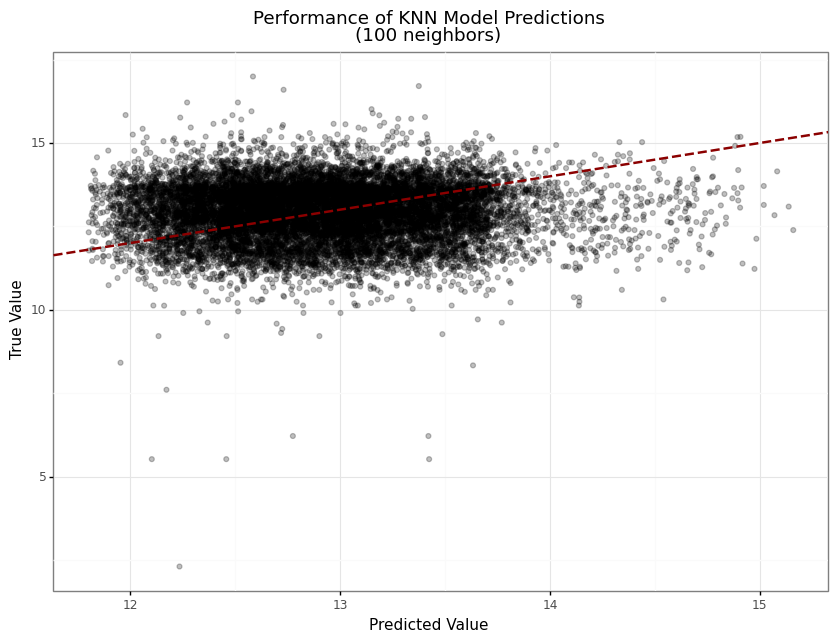

<ggplot: (166171975551)>

In [32]:
(
    ggplot(prediction,
          aes(x='prediction',y='LN_PRICE')) +
    geom_point(alpha=.25) +
    labs(x= "Predicted Value", y= "True Value", title= "Performance of KNN Model Predictions\n(100 neighbors)") + 
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

### Summary

Among all models tested, KNN with 100 neighbors demonstrated the lowest Mean Squared Error (MSE) among the training model with a score of -0.486.  When this model is applied to the test data set, the MSE is 0.477. This is lower than the MSE shown in the pipeline and in the initial tuning test where the MSE was -0.542. Honestly, I am confused about comparing the MSE when I initially tuned KNN with the MSE of the tuned Decision Tree and Random Forest before using the pipeline. The Decision Tree MSE and Random Forest MSE, -0.487 and -0.514 respectively, are closer to 0 than the KNN MSE of -0.542, yet the KNN is the best scoring when I use the pipeline with a score of -0.486. I believe this discrepancy is related to the fold generator in some way.